# Homework 3 - Ames Housing Dataset

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [479]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly_express as px
init_notebook_mode(connected=False)
from matplotlib import cm

In [451]:
# Initial data reading

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_Id = train['Id']
test_Id = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Data Cleaning. Filling NA values and converting categorical columns to nominal.
qualMap = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
for c in ['HeatingQC', 'KitchenQual', 'BsmtQual','ExterQual','ExterCond','BsmtCond','GarageQual','GarageCond','PoolQC']:
    train[c]=train[c].fillna("NA")
    train[c]=train[c].replace(qualMap)
    train[c]=train[c].astype(int)
fMap = {'CBlock':5,'PConc':4,'BrkTil':3,'Slab':2,'Stone':1,'Wood':0}
train['Foundation']=train['Foundation'].fillna("NA")
train['Foundation']=train['Foundation'].replace(fMap)
train['Foundation']=train['Foundation'].astype(int)
salePrice=train.copy()
train['SalePrice'] = train['SalePrice'].apply(lambda x: math.log1p(x))
for col in ['MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    train[col]=train[col].fillna('None')
for col in ['GarageArea','GarageCars','MasVnrArea']:
    train[col]=train[col].fillna(0)
for col in ['Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional']:
    train[col]=train[col].fillna(train[col].mode()[0])
train['LotFrontage']=train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train.drop(['Utilities'],axis=1,inplace=True)
for col in ['MoSold','MSSubClass','YrSold','OverallCond']:
    train[col]=train[col].astype(str)
train['BsmtGrade'] = train['BsmtQual'] * train['BsmtCond']
train['TotalArea'] = train['TotalBsmtSF'] + train['GrLivArea']
train['TotalFlrSF'] = train['1stFlrSF'] + train['2ndFlrSF']
train['TotalBath'] = train['BsmtFullBath'] + 0.5 * train['BsmtHalfBath'] + train['FullBath'] + 0.5 * train['HalfBath']
train['OverallCond']=train['OverallCond'].astype(int)

## Part 1 - Pairwise Correlations

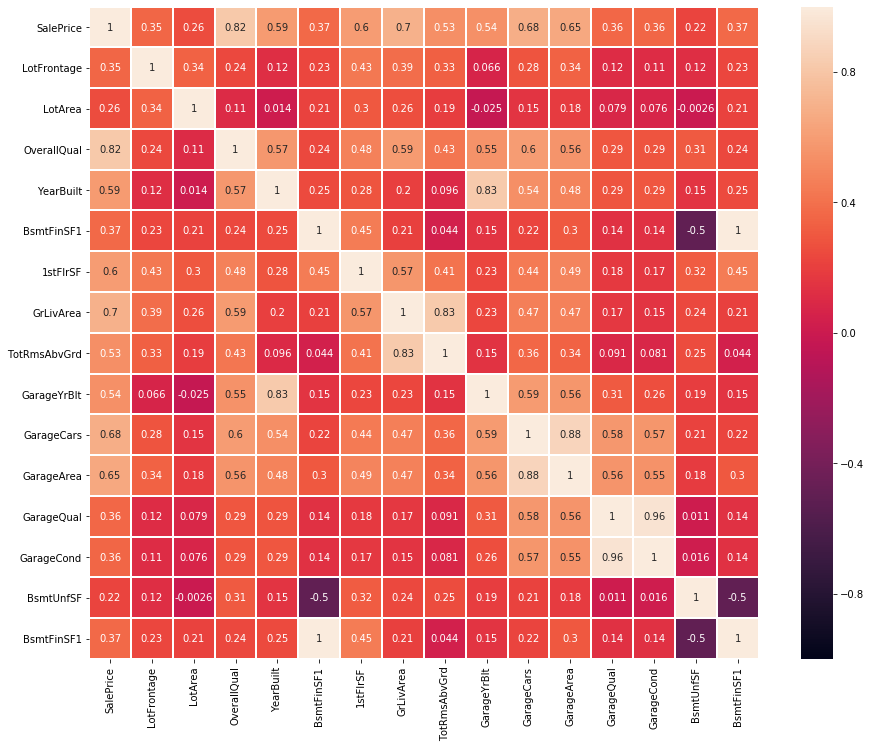

In [452]:
# plotting the heatmap for only a few selected values which gave good correlation values
fields = ['SalePrice','LotFrontage','MSSubClass','LotArea','OverallQual','YearBuilt','BsmtFinSF1','1stFlrSF','GrLivArea','TotRmsAbvGrd','GarageYrBlt','GarageCars','GarageArea','GarageQual','GarageCond','BsmtUnfSF','BsmtFinSF1']
plt.figure(figsize=(15,12))
sns.heatmap(train[fields].corr(method = "pearson"), vmin=-1, vmax=1, linewidths=1, annot = True);

Discuss most positive and negative correlations.

The highest correlation seen in the above heatmap is between GarageQual and GarageCond with a value of 0.88.

The highest correlation that helps with the modelling seen in the above heatmap is between OverallQual and SalePrice with a value of 0.82.
The correlation is a genuine one because OverallQual is a feature that describes a house's quality evaluation which will eventually increase it's price.

The least correlation seen in the above heatmap is between BsmtFinSF1 and BsmtUnfSF with a value of-0.5.
The correlation is a genuine one since the unfinished surface area of basement is inversely proportional to the finished surface area of the basement.

## Part 2 - Informative Plots

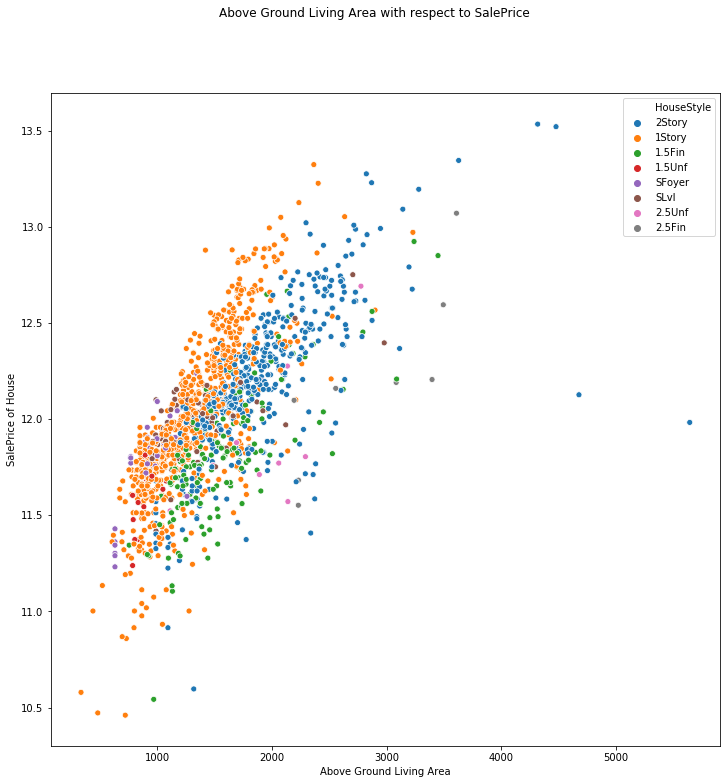

In [453]:
# TODO: code to generate Plot 1
plt.figure(figsize=(12,12))
plt.suptitle("Above Ground Living Area with respect to SalePrice")
splot=sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'],hue=train['HouseStyle'])
splot.set_xlabel("Above Ground Living Area")
splot.set_ylabel("SalePrice of House");

What interesting properties does Plot 1 reveal?

We see that as the GrLivArea increases, the SalePrice is increasing linearly. So we observe a good correlation between the data and GrLivArea couls be a potential important feature in designing the prediction model.

Text(0, 0.5, 'SalePrice')

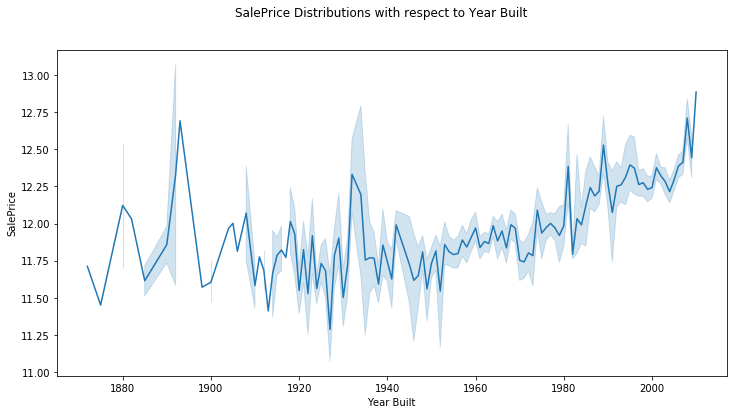

In [454]:
# TODO: code to generate Plot 2
plt.figure(figsize=(12,6))
plt.suptitle("SalePrice Distributions with respect to Year Built")
val=train[['SalePrice','YearBuilt']]
lplot=sns.lineplot(x=val['YearBuilt'], y=val['SalePrice'])
lplot.set_xlabel("Year Built")
lplot.set_ylabel("SalePrice")

What interesting properties does Plot 2 reveal?

We see that a few houses which are quite old have been sold for a price greater than most of the new houses. These houses could be considered antique which attracts antique collectors.

Also, we see that houses built recently fetch a better price than old ones.

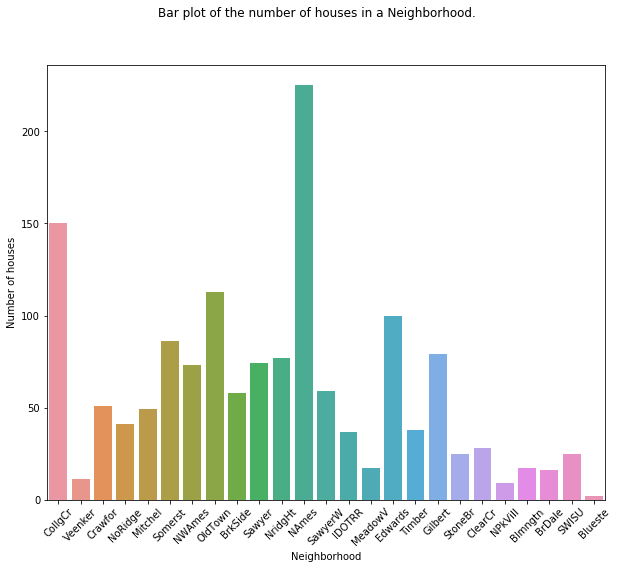

In [455]:
# TODO: code to generate Plot 3
plt.figure(figsize=(10,8))
plt.suptitle("Bar plot of the number of houses in a Neighborhood.")
bplot=sns.countplot(x=train['Neighborhood'])
bplot.set_xlabel("Neighborhood")
bplot.set_ylabel("Number of houses")
bplot.set_xticklabels(bplot.get_xticklabels(),rotation=45);

What interesting properties does Plot 3 reveal?

We see that most of the houses sold are from the neighborhoods NAmes and CollgCr. So these neighborhoods could be considered as the most preferred neighborhoods which can be further confirmed by analyzing the prices of the houses sold in these neighborhoods.

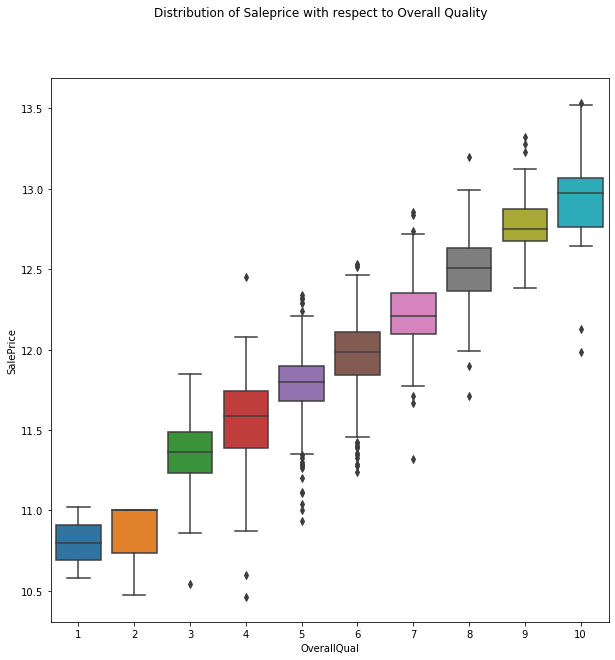

In [456]:
# TODO: code to generate Plot 4
plt.figure(figsize=(10,10))
plt.suptitle("Distribution of Saleprice with respect to Overall Quality")
bxplot.set_xlabel("Overall Quality")
bxplot.set_ylabel("SalePrice")
bxplot=sns.boxplot(x=train['OverallQual'],y=train['SalePrice'])

What interesting properties does Plot 4 reveal?

Since we see a high correlation between SalePrice and OverallQual, I plotted a boxplot between the 2 features on how the correlation can be improved by excluding the outliers. I see that the houses in the bins of OverallQual value 5 and 6 have a lot of outliers which might cause skewed model.

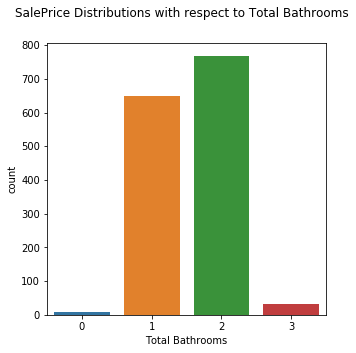

In [457]:
# TODO: code to generate Plot 5
plt.figure(figsize=(5,5))
plt.suptitle("SalePrice Distributions with respect to Total Bathrooms")
cplot=sns.countplot(x=train['FullBath'])
cplot.set_xlabel("Total Bathrooms");

What interesting properties does Plot 5 reveal?

We see that most of the houses have only 1-2 baths. We can also see that houses with less than 1 bath are rarely purchased.

## Part 3 - Handcrafted Scoring Function

In [458]:
# TODO: code for scoring function

# Chose certain columns which might have a considerable ontribution towards a big or a small SalePrice.
train['Desirability'] = (train['OverallQual']*train['OverallCond']*0.4)+(train['TotalArea']*0.02)+(train['KitchenQual']*train['KitchenAbvGr']*0.2)+(train['TotalFlrSF']*0.005)+(train['BsmtGrade']*3)++(train['GarageQual']*train['GarageCond']*3)+(train['TotalBath']*5)+(train['ExterCond']*train['ExterQual']*0.2)

#### Most Desirable Houses

In [459]:
desire=train.copy()

# Sorting in Descending order to get the houses with top scores.
desire.sort_values('Desirability',ascending=False).head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298         60       RL        313.0    63887   Pave  None      IR3   
523          60       RL        130.0    40094   Pave  None      IR1   
1182         60       RL        160.0    15623   Pave  None      IR1   
691          60       RL        104.0    21535   Pave  None      IR1   
1169         60       RL        118.0    35760   Pave  None      IR1   
496          20       RL         91.0    12692   Pave  None      IR1   
185          75       RM         90.0    22950   Pave  None      IR2   
440          20       RL        105.0    15431   Pave  None      Reg   
1373         20       RL         91.0    11400   Pave  None      Reg   
798          60       RL        104.0    13518   Pave  None      Reg   

     LandContour LotConfig LandSlope  ... MoSold YrSold SaleType  \
1298         Bnk    Corner       Gtl  ...      1   2008      New   
523          Bnk    Inside       Gtl  ...     10   2007      New   
1182         Lvl    Corner       Gtl  ...      7   2007       WD   
691          Lvl    Corner       Gtl  ...      1   2007       WD   
1169         Lvl   CulDSac       Gtl  ...      7   2006       WD   
496          Lvl    Inside       Gtl  ...      5   2007       WD   
185          Lvl    Inside       Gtl  ...      6   2006       WD   
440          Lvl    Inside       Gtl  ...      4   2009       WD   
1373         Lvl    Inside       Gtl  ...      3   2007       WD   
798          Lvl    Inside       Gtl  ...      7   2009      New   

     SaleCondition  SalePrice  BsmtGrade  TotalArea  TotalFlrSF  TotalBath  \
1298       Partial  11.982935         15      11752        5642        4.5   
523        Partial  12.126764         15       7814        4676        4.5   
1182       Abnorml  13.521141         15       6872        4476        4.5   
691         Normal  13.534474         15       6760        4316        4.0   
1169        Normal  13.345509         15       5557        3627        4.5   
496         Normal  12.971543         12       6428        3228        4.0   
185         Normal  13.071072          9       4715        3036        2.5   
440         Normal  13.226725         15       5496        2402        3.0   
1373        Normal  13.053015         15       5266        2633        3.5   
798        Partial  13.091906         15       5066        3140        3.5   

     Desirability  
1298      381.750  
523       298.160  
1182      277.720  
691       276.780  
1169      247.775  
496       246.900  
185       234.180  
440       232.930  
1373      231.985  
798       228.520  

[10 rows x 84 columns]

#### Least Desirable Houses

In [460]:
# Sorting in Ascending order to get the houses with least scores.
desire.sort_values('Desirability',ascending=True).head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
533          20       RL         50.0     5000   Pave  None      Reg   
1218         50       RM         52.0     6240   Pave  None      Reg   
1179         20       RL         77.0     8335   Pave  None      Reg   
705         190       RM         70.0     5600   Pave  None      Reg   
39           90       RL         65.0     6040   Pave  None      Reg   
1321         20       RL         52.0     6627   Pave  None      IR1   
375          30       RL         65.5    10020   Pave  None      IR1   
636          30       RM         51.0     6120   Pave  None      Reg   
1000         20       RL         74.0    10206   Pave  None      Reg   
520         190       RL         60.0    10800   Pave  Grvl      Reg   

     LandContour LotConfig LandSlope  ... MoSold YrSold SaleType  \
533          Low    Inside       Mod  ...      1   2007       WD   
1218         Lvl    Inside       Gtl  ...      7   2006       WD   
1179         Lvl    Corner       Gtl  ...      4   2006       WD   
705          Lvl    Inside       Gtl  ...      7   2010       WD   
39           Lvl    Inside       Gtl  ...      6   2008       WD   
1321         Lvl    Corner       Gtl  ...      7   2008       WD   
375          Low    Inside       Sev  ...      3   2009       WD   
636          Lvl    Inside       Gtl  ...      1   2009    ConLw   
1000         Lvl    Corner       Gtl  ...      7   2009       WD   
520          Lvl    Inside       Gtl  ...      8   2008       WD   

     SaleCondition  SalePrice  BsmtGrade  TotalArea  TotalFlrSF  TotalBath  \
533         Normal  10.579005          0        334         334        1.0   
1218        Normal  11.296025          0        912         912        1.0   
1179        Normal  11.440366          0       1124        1124        1.0   
705         Normal  10.915107          0       1092        1092        2.0   
39         AdjLand  11.314487          0       1152        1152        2.0   
1321        Normal  11.191356          0        720         720        1.0   
375         Normal  11.018646          2       1587         904        1.5   
636         Normal  11.002117          6       1064         800        1.0   
1000        Normal  11.314487          0        944         944        1.0   
520         Normal  11.573559          0       1294        1294        2.0   

     Desirability  
533         15.75  
1218        38.20  
1179        45.50  
705         46.90  
39          49.40  
1321        50.60  
375         51.36  
636         51.88  
1000        52.40  
520         56.55  

[10 rows x 84 columns]

#### Scoring mechanism

In [461]:
# Printing the correlation of our handcrafted score with SalePrice.
print(train['Desirability'].corr(train['SalePrice']))

0.8777196210348981


I have considered the below columns to design the handcrafted scoring function, each contributing a specific weight towards the final score.

Desirability

OverallQual

OverallCond

TotalArea

KitchenQual

KitchenAbvGr

TotalFlrSF

BsmtCond

BsmtQual

GarageQual

GarageCond

ExterCond

ExterQual

BsmtFullBath

BsmtHalfBath

FullBath

HalfBath

I see that the desirability score has worked really well from the fact that is is highly correlayted with the SalePrice.

## Part 4 - Pairwise Distance Function

In [462]:
# TODO: code for distance function
fie=[]

# Getting all the nominal columns in the list fie.
for i in train.columns:
    if train[i].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        if i != 'GarageYrBlt':
            fie.append(i)
result = train[fie]
# Normalizing all the values in result dataframe
for feature_name in fie:
    max_value = train[feature_name].max()
    min_value = train[feature_name].min()
    result[feature_name] = (result[feature_name]) / (max_value);
# Defining the pairwise distance function on the normalized data.
x=pd.DataFrame(euclidean_distances(result[fie]))
x=x.sort_values(0)
x.head(5)

C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0         1         2         3         4         5         6     \
0     0.000000  1.169521  0.390461  1.063859  0.608332  1.211198  0.888441   
1240  0.093875  1.180294  0.375153  1.058699  0.583711  1.224249  0.895021   
1366  0.109196  1.178395  0.363093  1.056381  0.596557  1.210036  0.895705   
1365  0.189511  1.172285  0.380542  1.048716  0.621436  1.206878  0.900362   
1410  0.216777  1.163302  0.358803  1.050292  0.632626  1.198753  0.894405   

          7         8         9     ...      1450      1451      1452  \
0     0.962524  1.258356  1.293519  ...  1.441629  1.139358  0.941032   
1240  0.959883  1.241548  1.307403  ...  1.426764  1.102211  0.962945   
1366  0.945665  1.255507  1.304849  ...  1.442172  1.123200  0.952071   
1365  0.965737  1.253003  1.305868  ...  1.451896  1.106634  0.944361   
1410  0.978452  1.251157  1.296838  ...  1.448422  1.111358  0.948929   

          1453      1454      1455      1456      1457      1458      1459  
0     1.532070  0.779159  0.711924  1.230038  1.394351  1.339628  1.219018  
1240  1.518547  0.768192  0.682363  1.224914  1.376492  1.353648  1.232365  
1366  1.531575  0.769422  0.696350  1.233763  1.389041  1.350348  1.227508  
1365  1.528963  0.751674  0.687358  1.238977  1.400046  1.348610  1.226208  
1410  1.527866  0.768231  0.687515  1.221102  1.393699  1.341224  1.225463  

[5 rows x 1460 columns]

In [463]:
# Printing the top values with least pairwise distance values to compare SalePrice
idList =[0,1240,1366,1365,1410]
saleP ={}
for idx in idList:
  sp = salePrice['SalePrice'].iloc[idx]
  saleP[idx]=sp
print(saleP)

{0: 208500, 1240: 224900, 1366: 193000, 1365: 216000, 1410: 230000}


How well does the distance function work? When does it do well/badly?

We see that the sale price of the top 5 houses with least pairwise distances are very close to each other. The prices of these houses are very close to each other.

In [464]:
x=x.sort_values(0,ascending=False)
x.head(5)

0         1         2         3         4         5         6     \
1298  2.844171  3.049677  2.748983  3.008864  2.548135  3.226953  2.634346   
533   2.329332  2.281517  2.349162  2.291114  2.600159  2.169484  2.470954   
705   2.111934  2.152924  2.153858  2.163415  2.341247  2.129105  2.328278   
1179  2.069543  2.004601  2.049785  1.955888  2.262288  2.037524  2.145889   
1218  2.040463  2.037988  2.065156  2.061929  2.305469  1.971886  2.201620   

          7         8         9     ...      1450      1451      1452  \
1298  2.634045  3.044550  3.150012  ...  3.381748  2.873323  3.226774   
533   2.533139  2.097214  1.998404  ...  2.144111  2.490037  1.924895   
705   2.311242  1.843594  1.941259  ...  1.867573  2.364794  1.941150   
1179  2.138778  1.718853  1.709148  ...  2.010682  2.157276  1.816059   
1218  2.283581  1.870541  1.781986  ...  1.975796  2.209523  1.761669   

          1453      1454      1455      1456      1457      1458      1459  
1298  3.465264  3.011188  2.967484  2.716213  2.937419  3.348881  3.148227  
533   1.737149  2.190442  2.216509  2.334714  2.549123  2.022915  2.156104  
705   1.730799  2.089204  2.044094  2.189946  2.246476  2.020759  2.114178  
1179  1.520470  1.948377  1.956762  2.065049  2.085600  1.842630  1.984661  
1218  1.486226  1.926725  1.975843  2.169282  2.174679  1.831184  1.960370  

[5 rows x 1460 columns]

In [465]:
# Printing the top values with highest pairwise distance values to compare SalePrice
idList =[0,1298,533,705,1179,1218]
saleP ={}
for idx in idList:
  sp = salePrice['SalePrice'].iloc[idx]
  saleP[idx]=sp
print(saleP)

{0: 208500, 1298: 160000, 533: 39300, 705: 55000, 1179: 93000, 1218: 80500}


How well does the distance function work? When does it do well/badly?

We see that the sale price of the top 5 houses with highest pairwise distances are very different to each other. There is a huge difference between their prices.

After maing the above observations, I feel that the handcrafted pairwise distance works really well.

## Part 5 - Clustering

In [466]:
# TODO: code for clustering and visualization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
pca = PCA(n_components=48).fit(result)
expvar=np.cumsum(pca.explained_variance_ratio_)
configure_plotly_browser_state()
init_notebook_mode(connected=True)
data = [go.Scatter(y=expvar)]
layout = {'title': 'Review PCA Explained Variance to determine number of components'}
iplot({'data':data,'layout':layout})
pca = PCA(n_components=30)
XPCA = pca.fit_transform(result)
numberClusters=8
kmeans = KMeans(n_clusters=numberClusters, random_state=69)
Xkmeans = kmeans.fit_predict(XPCA)
XTSNE = TSNE(n_components=2).fit_transform(XPCA)
y = result.SalePrice.reset_index(drop=True)

In [467]:
XTSNEdf = pd.concat([pd.DataFrame(XTSNE),pd.DataFrame(Xkmeans),pd.DataFrame(y),pd.DataFrame(np.expm1(y)),pd.DataFrame()],axis=1)
XTSNEdf.columns = ['x1','x2','cluster','logprice','price']
configure_plotly_browser_state()
init_notebook_mode(connected=True)
px.scatter(XTSNEdf,x='x1',y='x2',color='cluster',color_continuous_scale=px.colors.qualitative.Plotly,title="TSNE visualization of House Clusters",width=800,height=500)

#### Analysis of clusters

We have clustered houses based on the our distance scoring function and now we can compare the houses in the same cluster based on their Neighborhood. House # 4,11,20,35,58 and others in the list belongs to same cluster (number 2) and have Neighborhood NridgHt.

House # 13,22,25,32,45 and others in the list belongs to same cluster (number 4) and have Neighborhood CollgCr.

## Part 6 - Linear Regression

In [468]:
# Reading data from file with different variable names so that we do not mix the normamlized data.
from sklearn.linear_model import LinearRegression
ttrain = pd.read_csv("train.csv")
ttest = pd.read_csv("test.csv")
ttrain_Id = ttrain['Id']
ttrain.drop("Id", axis = 1, inplace = True)
ttest.drop("Id", axis = 1, inplace = True)
qualMap = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
for c in ['HeatingQC', 'KitchenQual', 'BsmtQual','ExterQual','ExterCond','BsmtCond','GarageQual','GarageCond','PoolQC']:
    ttrain[c]=ttrain[c].fillna("NA")
    ttrain[c]=ttrain[c].replace(qualMap)
    ttrain[c]=ttrain[c].astype(int)
fMap = {'CBlock':5,'PConc':4,'BrkTil':3,'Slab':2,'Stone':1,'Wood':0}
ttrain['Foundation']=ttrain['Foundation'].fillna("NA")
ttrain['Foundation']=ttrain['Foundation'].replace(fMap)
ttrain['Foundation']=ttrain['Foundation'].astype(int)
for col in ['MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    ttrain[col]=train[col].fillna('None')
for col in ['GarageArea','GarageCars','MasVnrArea']:
    ttrain[col]=ttrain[col].fillna(0)
for col in ['Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional']:
    ttrain[col]=ttrain[col].fillna(ttrain[col].mode()[0])
ttrain['LotFrontage']=ttrain.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
ttrain.drop(['Utilities'],axis=1,inplace=True)
for col in ['MoSold','MSSubClass','YrSold','OverallCond']:
    ttrain[col]=ttrain[col].astype(str)
ttrain['BsmtGrade'] = ttrain['BsmtQual'] * ttrain['BsmtCond']
ttrain['TotalArea'] = ttrain['TotalBsmtSF'] + ttrain['GrLivArea']
ttrain['TotalFlrSF'] = ttrain['1stFlrSF'] + ttrain['2ndFlrSF']
ttrain['TotalBath'] = ttrain['BsmtFullBath'] + 0.5 * ttrain['BsmtHalfBath'] + ttrain['FullBath'] + 0.5 * ttrain['HalfBath']
ttrain['OverallCond']=ttrain['OverallCond'].astype(int)
sp=ttrain['SalePrice']
ttrain=ttrain.drop(["SalePrice"], axis = 1)

In [469]:
from sklearn.preprocessing import LabelEncoder
import math

fie1=[]
for i in ttrain.columns:
    if ttrain[i].dtypes in ['int16','int32','int64','float16','float32','float64'] and i!='GarageYrBlt':
        fie1.append(i)
rgr = LinearRegression()
mScore=999999999999999999
mCol=fie1[0]
for i in range(len(fie1)):
    for j in range(i,len(fie1)):
        X_train, X_test, y_train, y_test = train_test_split(ttrain[[fie1[i],fie1[j]]],sp, test_size=0.2)
        rgr = LinearRegression()
        rgr.fit(X_train,y_train)
        preds=rgr.predict(X_test)
        from sklearn.metrics import mean_squared_error
        score = mean_squared_error(preds,y_test)
        if (score <= mScore):
            mScore=score
            mCol=[fie1[i],fie1[j]]
print(math.sqrt(mScore))
print(mCol)

36247.66699216135
['YearRemodAdd', 'TotalArea']


#### How well/badly does it work? Which are the most important variables?

Everytime I run the above model, which takes 2 of the nominal features and runs the regression model, it prints the combination of features that gives the best RMSE score.

After running it multiple times, I see that the most repeated features are as below.

TotalArea

GrLivArea

TotalFlrSF

OverallQual

YearRemodAdd

KitchenQual

I would categorize the above features as the most important once.

But when we discuss about the model itself, using the simple linear regression model on one or few colums gives a very bad prediction since:

1) The dataset is small. Only 1460 rows.

2) The number of features used to predict are less(2 or less)

## Part 7 - External Dataset

### External Dataset: https://www.cityofames.org/government/departments-divisions-a-h/city-assessor/reports

#### About the data:
About Dataset: This dataset contains house data IOWA state with features similar to our data, but these houses are built in recent years(2016-2019) with the latest year being 2019. Now with the help of this dataset we can see the trend of the Sale Price in recent years.



The data was extensive with around 22000 records but since most of the records did not have the saleprice, we were only able to include around 3000 records. I have combined the external dataset with the original one and trying to see how a prediction on this set varies.

In [506]:
# TODO: code to import external dataset and test
extData = pd.read_csv("extData.csv")
extCols = list(extData.columns)
def mapCols(columns,df,mapDict):
    df[columns] = df[columns].map(mapDict)
    return df
buildTypeMap = {}
buildTypeMap['1FamDet'] = '1Fam'
buildTypeMap['2FmConv'] = '2FmCon'
buildTypeMap['Duplex'] = 'Duplx'
buildTypeMap['Twnhs-E'] = 'TwnhsE'
buildTypeMap['Twnhs-I'] = 'TwnhsI'

houseStyleMap ={}
houseStyleMap['1-Story'] = '1Story'
houseStyleMap['1.5 Fin'] = '1.5Fin'
houseStyleMap['1.5 Unf'] = '1.5Unf'
houseStyleMap['2-Story'] = '2Story'
houseStyleMap['2.5 Fin'] = '2.5Fin'
houseStyleMap['2.5 Unf'] = '2.5Unf'
houseStyleMap['S/Foyer'] = 'SFoyer'
houseStyleMap['S/Level'] = 'SLvl'

garageTypeMap = {}
garageTypeMap['2 Types'] = '2Types'
garageTypeMap['Attachd'] = 'Attchd'
garageTypeMap['Basment'] = 'Basment'
garageTypeMap['Detached'] = 'Detchd'
garageTypeMap['None'] = 'NA'

saleTypeMap ={}
saleTypeMap['WRDCash'] = 'CWD'
saleTypeMap['WRDConv'] = 'VWD'
saleTypeMap['NewSold'] = 'New'
saleTypeMap['COD/Est'] = 'COD'
saleTypeMap['CtrLwDn'] = 'ConLw'
saleTypeMap['CtrLInt'] = 'ConLI'
saleTypeMap['CtrLD&I'] = 'ConLD'
saleTypeMap['Other'] = 'Oth'

extData = mapCols('BldgType',extData,buildTypeMap)
extData = mapCols('HouseStyle',extData,houseStyleMap)
extData = mapCols('GarageType',extData,garageTypeMap)
extData = mapCols('SaleType',extData,saleTypeMap)

extData['GarageType']=extData['GarageType'].fillna('None') 
extData['HouseStyle']=extData['HouseStyle'].fillna('None') 
extData['SaleType'] = extData['SaleType'].fillna('None') 
extData['BldgType'] = extData['BldgType'].fillna('None') 
extData['SalePrice'] = np.log(extData['SalePrice'])
extData = extData.fillna(0)

In [507]:
extData.head(10)

LotArea BldgType  YearBuilt HouseStyle RoofMatl Exterior1st Exterior2nd  \
0    10015     1Fam       2016     2Story  CompShg     VinylSd     VinylSd   
1    10015     1Fam       2016     2Story  CompShg     VinylSd     VinylSd   
2    14904     1Fam       2018     2Story  CompShg     VinylSd     VinylSd   
3    14904     1Fam       2018     2Story  CompShg     VinylSd     VinylSd   
4    13915     1Fam       2017     1Story  CompShg     CemntBd     CmentBd   
5    13915     1Fam       2017     1Story  CompShg     CemntBd     CmentBd   
6     9200     1Fam       2018     1Story  CompShg     VinylSd     VinylSd   
7     9200     1Fam       2018     1Story  CompShg     VinylSd     VinylSd   
8     9200     1Fam       2018     1Story  CompShg     VinylSd     VinylSd   
9     7153   TwnhsE       2017     1Story  CompShg     VinylSd     VinylSd   

  MasVnrType Heating CentralAir  ...  PoolArea  GarageType  GarageYrBlt  \
0    BrkFace    GasA          Y  ...         0      Attchd         2016   
1    BrkFace    GasA          Y  ...         0      Attchd         2016   
2      Stone    GasA          Y  ...         0      Attchd         2018   
3      Stone    GasA          Y  ...         0      Attchd         2018   
4      Stone  GasFWA        Yes  ...         0      Attchd         2017   
5      Stone  GasFWA        Yes  ...         0      Attchd         2017   
6      Stone  GasFWA        Yes  ...         0      Attchd         2018   
7      Stone  GasFWA        Yes  ...         0      Attchd         2018   
8      Stone  GasFWA        Yes  ...         0      Attchd         2018   
9      Stone  GasFWA        Yes  ...         0      Attchd         2017   

   GarageArea  YrSold MoSold  SalePrice  SaleType  SaleCondition  BedroomAbvGr  
0         647    2017     10  12.808748       VWD         Normal             4  
1         647    2016      5  11.225243       VWD         Normal             4  
2         744    2019      1  12.880292       VWD         Normal             4  
3         744    2018      1  11.225243       VWD         Normal             4  
4        1057    2018      6  13.128176       New        Partial             2  
5        1057    2017      4   8.713582       VWD        Abnorml             2  
6         825    2018      5  12.914773       New        Partial             2  
7         825    2017     12  11.238489       VWD         Normal             2  
8         825    2017      4   8.293800       VWD        Abnorml             2  
9         473    2017      9  12.579359       New        Partial             2  

[10 rows x 24 columns]

In [650]:
originaldf = pd.read_csv("train.csv")
originaldf.drop("Id", axis = 1, inplace = True)
qualMap = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
for c in ['HeatingQC', 'KitchenQual', 'BsmtQual','ExterQual','ExterCond','BsmtCond','GarageQual','GarageCond','PoolQC']:
    originaldf[c]=originaldf[c].fillna("NA")
    originaldf[c]=originaldf[c].replace(qualMap)
    originaldf[c]=originaldf[c].astype(int)
fMap = {'CBlock':5,'PConc':4,'BrkTil':3,'Slab':2,'Stone':1,'Wood':0}
originaldf['Foundation']=originaldf['Foundation'].fillna("NA")
originaldf['Foundation']=originaldf['Foundation'].replace(fMap)
originaldf['Foundation']=originaldf['Foundation'].astype(int)
for col in ['MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    originaldf[col]=originaldf[col].fillna('None')
for col in ['GarageArea','GarageCars','MasVnrArea']:
    originaldf[col]=originaldf[col].fillna(0)
for col in ['Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional']:
    originaldf[col]=originaldf[col].fillna(train[col].mode()[0])
originaldf['LotFrontage']=originaldf.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
originaldf.drop(['Utilities'],axis=1,inplace=True)
for col in ['MoSold','MSSubClass','YrSold','OverallCond']:
    originaldf[col]=originaldf[col].astype(str)
originaldf['BsmtGrade'] = originaldf['BsmtQual'] * originaldf['BsmtCond']
originaldf['TotalArea'] = originaldf['TotalBsmtSF'] + originaldf['GrLivArea']
originaldf['TotalFlrSF'] = originaldf['1stFlrSF'] + originaldf['2ndFlrSF']
originaldf['OverallCond']=originaldf['OverallCond'].astype(int)

totalData = pd.concat([originaldf,extData], axis=0)
nonNumericExtList = totalData.select_dtypes([object]).columns.tolist()
fie=[]
for i in extCols:
    if i not in nonNumericExtList and i != 'GarageYrBlt':
        fie.append(i)

for i in fie:
    totalData[i].fillna('0')
totalData=totalData.drop(['GarageYrBlt'], axis=1)

C:\Users\abhin\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [649]:
trainingSet, testSet = train_test_split(totalData[fie], test_size=0.2)
XLabel = (np.log(trainingSet['SalePrice']))
Xtrain = trainingSet.drop('SalePrice',axis =1)
Ytest = testSet.drop('SalePrice', axis =1)
lr = LinearRegression()
lr.fit(Xtrain, XLabel)
#predict on test data split
pred = lr.predict(Ytest)
score = mean_squared_error(np.log(testSet['SalePrice']), (pred))
score = np.sqrt(score)
print(score)

4.550419373988922


Describe the dataset and whether this data helps with prediction.

I have run the linear regression model on nearly 4000 records and we have achieved an RMSE score of 4.55 which is not that great but can be improved by improving the data cleaning.

## Part 8 - Permutation Test

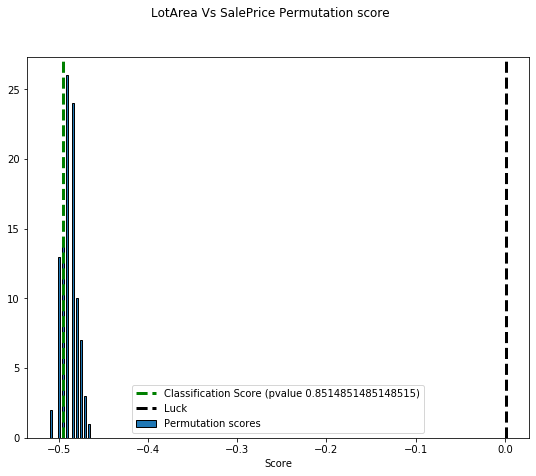

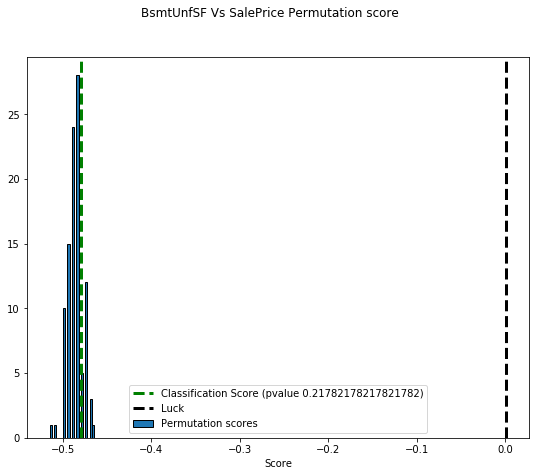

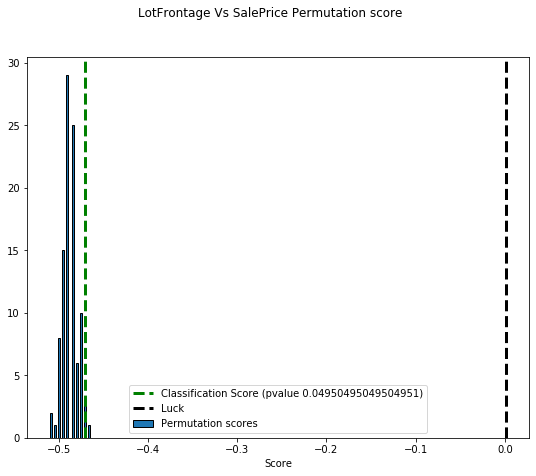

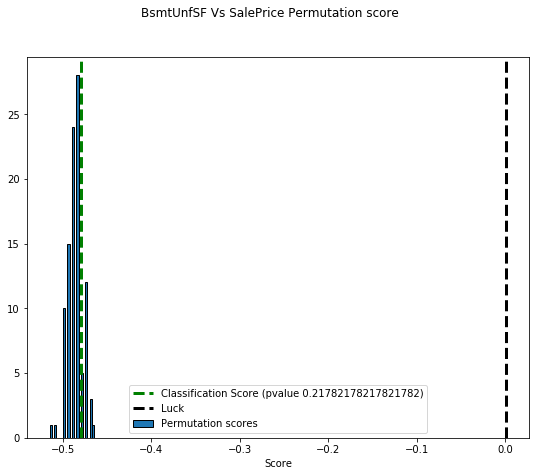

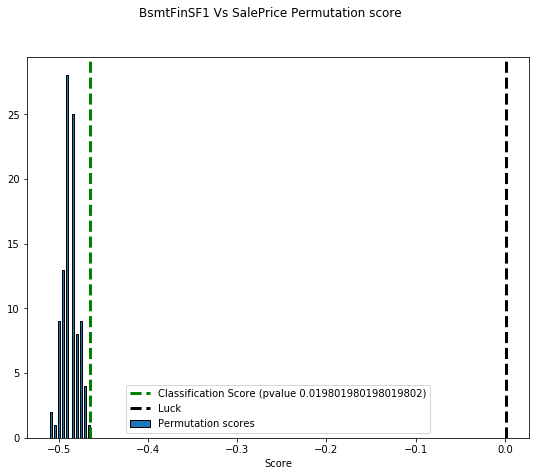

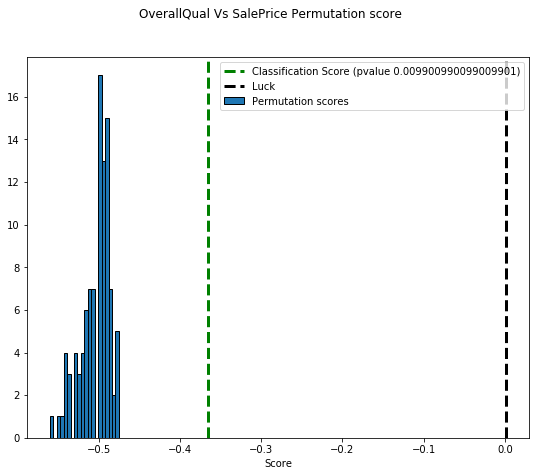

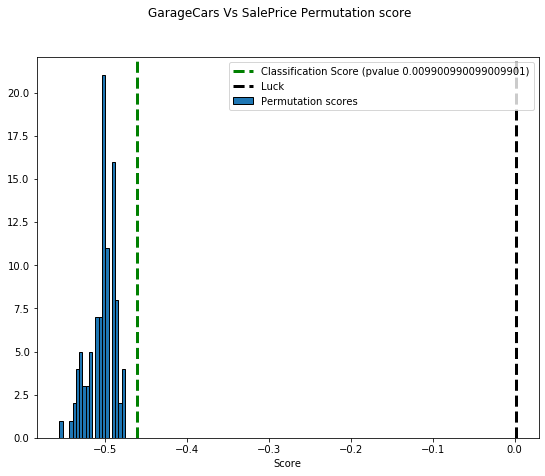

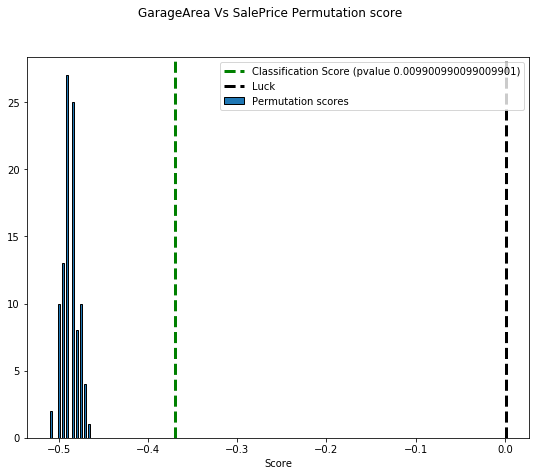

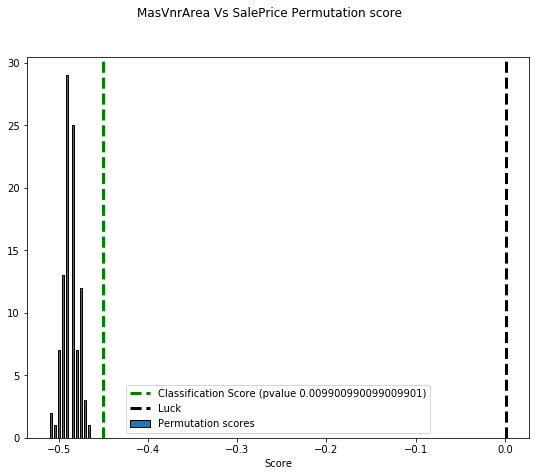

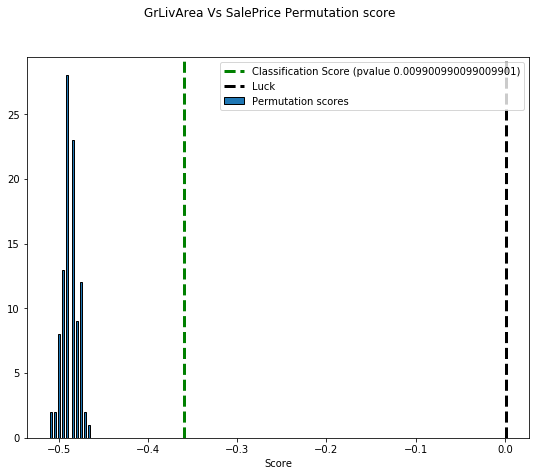

In [471]:
# TODO: code for all permutation tests
def permutationList(col):
    X = train[col]
    y = train['SalePrice']
    n_classes = np.unique(y).size
    random = np.random.RandomState(seed=77)
    E = random.normal(size=(len(X), 2200))
    X = np.c_[X, E]
    rgr = LinearRegression()
    cv = KFold(2)
    def rmse_self(y_true, y_pred):
        e = sqrt(mean_squared_error(y_true, y_pred))
        rmse = round(e, 2)
        return rmse
    score = make_scorer(rmse_self, greater_is_better=False)
    score, permutation_scores, pvalue = permutation_test_score (rgr, X, y, scoring=score, cv=cv, n_permutations=100, n_jobs=1,verbose=0)
    plt.figure(figsize=(9,7))
    plt.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=3, label='Classification Score (pvalue %s)' % pvalue)
    plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.suptitle(f"{col} Vs SalePrice Permutation score")
    plt.show();
fie1=['LotArea','BsmtUnfSF','LotFrontage','BsmtUnfSF','BsmtFinSF1','OverallQual','GarageCars','GarageArea','MasVnrArea','GrLivArea']
for cl in fie1:
    permutationList(cl)

Describe the results.

The below features give a very bad permutation test scores, which means that even if they gave a good correlation value in the heatmap in part-1, that was a coincidence and does not describe a genuine relationship between the feature and SalePrice.

['LotArea','BsmtUnfSF','LotFrontage','BsmtUnfSF','BsmtFinSF1']

The below columns give a good permutation test score which means that they are correlated well with SalePrice and their correlation values in Part-1 describe a genuine relationship between the feature and SalePrice.

['OverallQual','GarageCars','GarageArea','MasVnrArea','GrLivArea']

## Part 9 - Final Result

In [472]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_Id = train['Id']
test_Id = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
qualMap = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
for c in ['HeatingQC', 'KitchenQual', 'BsmtQual','ExterQual','ExterCond','BsmtCond','GarageQual','GarageCond','PoolQC']:
    train[c]=train[c].fillna("NA")
    train[c]=train[c].replace(qualMap)
    train[c]=train[c].astype(int)
fMap = {'CBlock':5,'PConc':4,'BrkTil':3,'Slab':2,'Stone':1,'Wood':0}
train['Foundation']=train['Foundation'].fillna("NA")
train['Foundation']=train['Foundation'].replace(fMap)
train['Foundation']=train['Foundation'].astype(int)
for col in ['MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    train[col]=train[col].fillna('None')
for col in ['GarageArea','GarageCars','MasVnrArea']:
    train[col]=train[col].fillna(0)
for col in ['Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional']:
    train[col]=train[col].fillna(train[col].mode()[0])
train['LotFrontage']=train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train.drop(['Utilities'],axis=1,inplace=True)
for col in ['MoSold','MSSubClass','YrSold','OverallCond']:
    train[col]=train[col].astype(str)
train['BsmtGrade'] = train['BsmtQual'] * train['BsmtCond']
train['TotalArea'] = train['TotalBsmtSF'] + train['GrLivArea']
train['TotalFlrSF'] = train['1stFlrSF'] + train['2ndFlrSF']
train['TotalBath'] = train['BsmtFullBath'] + 0.5 * train['BsmtHalfBath'] + train['FullBath'] + 0.5 * train['HalfBath']
train['OverallCond']=train['OverallCond'].astype(int)

qualMap = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
for c in ['HeatingQC', 'KitchenQual', 'BsmtQual','ExterQual','ExterCond','BsmtCond','GarageQual','GarageCond','PoolQC']:
    test[c]=test[c].fillna("NA")
    test[c]=test[c].replace(qualMap)
    test[c]=test[c].astype(int)
fMap = {'CBlock':5,'PConc':4,'BrkTil':3,'Slab':2,'Stone':1,'Wood':0}
test['Foundation']=test['Foundation'].fillna("NA")
test['Foundation']=test['Foundation'].replace(fMap)
test['Foundation']=test['Foundation'].astype(int)
for col in ['MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    test[col]=test[col].fillna('None')
for col in ['GarageArea','GarageCars','MasVnrArea']:
    test[col]=test[col].fillna(0)
for col in ['Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional']:
    test[col]=test[col].fillna(test[col].mode()[0])
test['LotFrontage']=test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test.drop(['Utilities'],axis=1,inplace=True)
for col in ['MoSold','MSSubClass','YrSold','OverallCond']:
    test[col]=test[col].astype(str)
test['BsmtGrade'] = test['BsmtQual'] * test['BsmtCond']
test['TotalArea'] = test['TotalBsmtSF'] + test['GrLivArea']
test['TotalFlrSF'] = test['1stFlrSF'] + test['2ndFlrSF']
test['TotalBath'] = test['BsmtFullBath'] + 0.5 * test['BsmtHalfBath'] + test['FullBath'] + 0.5 * test['HalfBath']

In [473]:
f12=[]
for i in test.columns:
    if test[i].dtype in ['object']:
        f12.append(i)
X_train, X_test, y_train, y_test = train_test_split(train.drop(["SalePrice"], axis = 1), train['SalePrice'], test_size=0.3)
clf = CatBoostRegressor(iterations=12000,task_type="GPU",devices='0:1',cat_features=f12)
clf.fit(X_train,y_train,verbose=False)
preds=clf.predict(X_test)
new_preds=clf.predict(test)
output=pd.DataFrame({'Id': test_Id, 'SalePrice': new_preds[:]})
output.to_csv('submission5.csv', index=False)

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/abhinaymadunanthu

Highest Rank: 1362

Score: 0.12423

Number of entries: 15

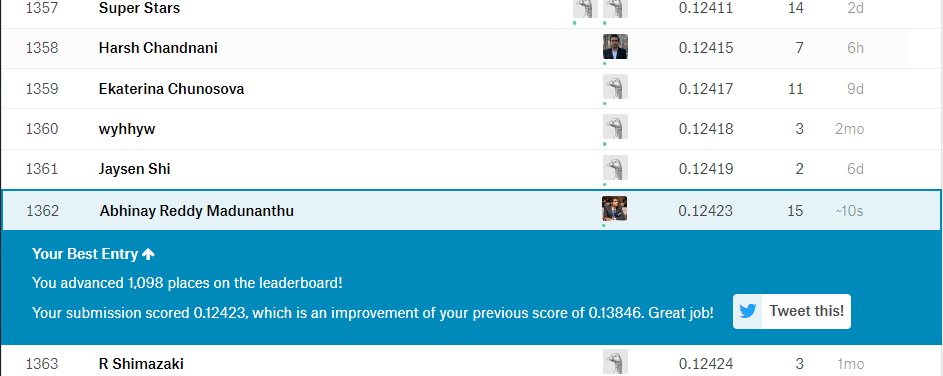